In [ ]:
import pathlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

1. Persiapan Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mendefinisikan path ke dataset di Google Drive
path_to_dataset = '/content/drive/MyDrive/Coba/Kain'

Membuat instance ImageDataGenerator untuk augmentasi gambar

In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

Memuat dataset dari Google Drive

In [ ]:
train_dataset = image_generator.flow_from_directory(
    directory=path_to_dataset,
    target_size=(224, 224),
    batch_size=32,
    subset='training'
)

validation_dataset = image_generator.flow_from_directory(
    directory=path_to_dataset,
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)

Found 359 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [ ]:
# Menentukan jumlah kelas (num_classes) berdasarkan jumlah subfolder dalam dataset
num_classes = len(train_dataset.class_indices)

2. Pembuatan Model

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

# Load the MobileNet model
pre_trained_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

pre_trained_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
# Menambahkan layer kustom di atas model pre-trained
model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile model
#from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

3. Pelatihan Model

In [ ]:
batch=30
history = model.fit(train_dataset,
              validation_data=validation_dataset,
              epochs=20,
              steps_per_epoch = train_dataset.samples//batch,
              validation_steps = validation_dataset.samples//batch,
              verbose = 1
          )

Epoch 1/20
11/11 [==============================] - 111s 9s/step - loss: 0.5056 - accuracy: 0.8012 - val_loss: 0.6469 - val_accuracy: 0.6406
Epoch 2/20
11/11 [==============================] - 84s 8s/step - loss: 0.1451 - accuracy: 0.9633 - val_loss: 0.6835 - val_accuracy: 0.7031
Epoch 3/20
11/11 [==============================] - 93s 8s/step - loss: 0.0871 - accuracy: 0.9773 - val_loss: 0.4117 - val_accuracy: 0.8438
Epoch 4/20
11/11 [==============================] - 98s 9s/step - loss: 0.0285 - accuracy: 0.9939 - val_loss: 0.3910 - val_accuracy: 0.8906
Epoch 5/20
11/11 [==============================] - 90s 8s/step - loss: 0.0227 - accuracy: 0.9969 - val_loss: 0.1494 - val_accuracy: 0.9375
Epoch 6/20
11/11 [==============================] - 88s 8s/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.2007 - val_accuracy: 0.9375
Epoch 7/20
11/11 [==============================] - 87s 8s/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.1737 - val_accuracy: 0.9375
Epoch 8/20
11/11 [=

4. Deskripsi Gambar

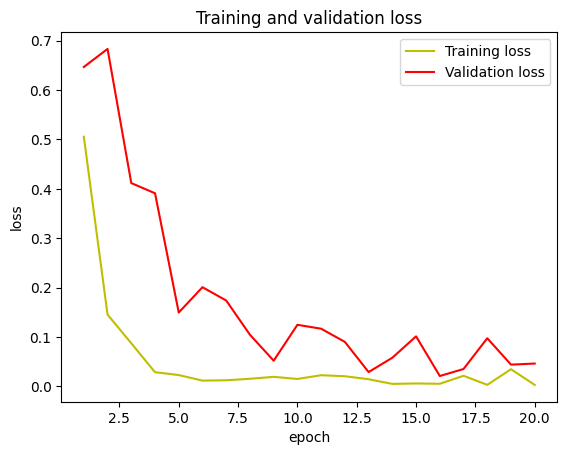

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'y',label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

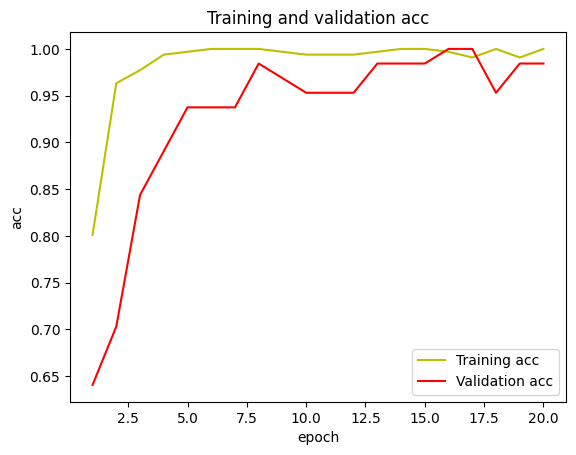

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs,acc,'y',label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Coba/model_kain.h5')
model=load_model('/content/drive/MyDrive/Coba/model_kain.h5')

In [ ]:
class_name = train_dataset.class_indices
class_name = list(dict.keys(class_name))
print(class_name)

['Kain', 'Organik']


In [ ]:
# Load the HDF5 model
model = tf.keras.models.load_model('/content/drive/MyDrive/Coba/model_kain.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to file
with open('model_kain.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Coba/model_kain.h5')

In [ ]:
# Mengklasifikasikan gambar menggunakan model
# Ambil contoh satu gambar untuk dijadikan deskripsi dan rekomendasi
image_path = '/content/kain6.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)
image_array = image_array / 255.0  # Normalisasi

In [ ]:
predictions = loaded_model.predict(image_array)
predicted_class = tf.argmax(predictions[0])

description = ""
if predicted_class == 0:
    description = "Ini adalah Kain."
elif predicted_class == 1:
    description = "Ini adalah Organik."

print(description)

NameError: ignored